# DDQN Single Stock Trading 
- 0-500 position size
- 3 Indicator ADX CCI RSI
- Subclassed Models

In [17]:
import h5py
import talib
import datetime
import random
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import pandas_datareader as pdr
from collections import deque
import tensorflow as tf
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import models, layers, optimizers
%matplotlib inline

In [18]:
start = datetime.datetime(2000, 2, 20)
end = datetime.datetime(2021, 2, 20)

In [19]:
stock = pdr.get_data_yahoo('THAI.BK', start=start, end=end)

In [20]:
len(stock['Adj Close'])

5231

<AxesSubplot:xlabel='Date'>

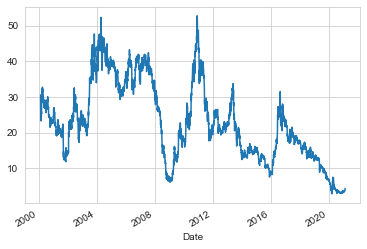

In [21]:
stock['Adj Close'][:].plot(grid=True)

In [22]:
adx = talib.ADX(stock['High'], stock['Low'], stock['Close'], timeperiod=14)
cci = talib.CCI(stock['High'], stock['Low'], stock['Close'], timeperiod=14)
rsi = talib.RSI(stock['Close'], timeperiod=14)
stock['ADX'] = adx
stock['CCI'] = cci
stock['RSI'] = rsi

In [23]:
data = stock[['Adj Close', 'ADX', 'CCI', 'RSI']].dropna()

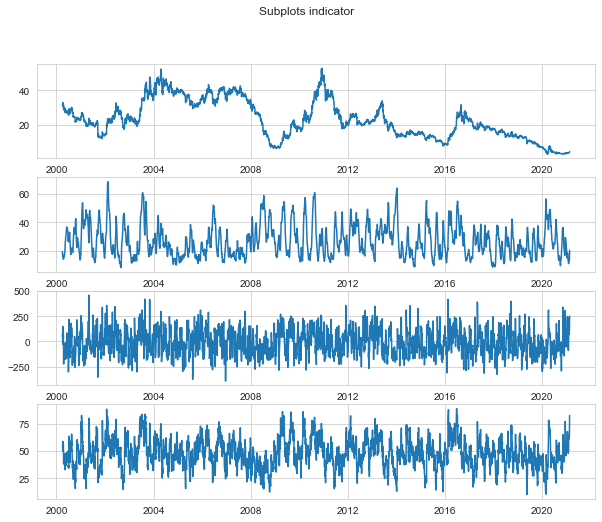

In [24]:
sns.set_style("whitegrid")

fig, axs = plt.subplots(data.shape[1], figsize=(10,8))
fig.suptitle('Subplots indicator')

for i in range(data.shape[1]):
    axs[i].plot(data.iloc[:,i])

plt.show()   

In [25]:
class DenseNetwork(models.Model):
    
    def __init__(self,input_sz, output_sz, hidden_sz):
        super(DenseNetwork, self).__init__()
        self.input_layer = layers.InputLayer(input_shape=(input_sz,))
        self.hidden_layer = [layers.Dense(i, activation='relu') for i in hidden_sz]
        self.output_layer = layers.Dense(output_sz, activation = 'linear')
        
    def call(self, x):
        x = self.input_layer(x)
        for l in self.hidden_layer:
            x = l(x)
        return self.output_layer(x)

In [26]:
class DDQNAgent():

    def __init__(self, 
                 state_size=None, 
                 action_size=None,
                 hidden_size=[64,64],
                 maxlen=10000,
                 lr=0.001,
                 batch_size=128,
                 gamma=0.99,
                 epsilon=1.0,
                 epsilon_decay_factor=0.9999,
                 epsilon_min = 0.01,
                 Architecture=DenseNetwork):
        
        self.state_size = state_size  
        self.action_size = action_size  
        
        self.discount_factor = gamma
        self.learning_rate = lr
        self.epsilon = epsilon
        self.epsilon_decay_factor = epsilon_decay_factor 
        self.epsilon_min = epsilon_min
        
        self.hidden_size = hidden_size
        
        self.model = Architecture(self.state_size, self.action_size, self.hidden_size)
        self.target_model = Architecture(self.state_size, self.action_size, self.hidden_size) 
        
        self.copy_weights(self.model, self.target_model)
        
        self.optimizer = tf.keras.optimizers.Adam(lr=self.learning_rate)

        self.maxlen = maxlen
        self.memory = deque(maxlen=self.maxlen) 
        self.batch_size = batch_size
        
        self.losses = []
    
    def __str__(self):
        return "Parameter(Discount:%s, Epsilon_decay:%s, Maxlen:%s, batch:%s)" %(self.discount_factor, 
                                                                                 self.epsilon_decay_factor, 
                                                                                 self.maxlen, 
                                                                                 self.batch_size)
    
    def copy_weights(self, Copy_from, Copy_to):
        var2 = Copy_from.trainable_variables
        var1 = Copy_to.trainable_variables
        for v1, v2 in zip(var1, var2):
            v1.assign(v2.numpy())

    def get_action(self, state):
        optimal_action = np.argmax(self.model.call(state)[0])
        random_action = random.randint(0, self.action_size - 1)
        action = np.random.choice([optimal_action, random_action], p=[1 - self.epsilon, self.epsilon])
        return action
    
    def save_sample(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay_factor
    
    def vanilla_loss(self, target, q):
        return tf.keras.losses.mse(target, q)
    
    def train_model(self):
        if len(self.memory) >= self.batch_size:
            state, action, reward, next_state, done = zip(*random.sample(self.memory, self.batch_size)) 

            state = tf.cast(np.vstack(state), dtype=tf.float32)
            action = tf.squeeze(tf.cast(np.vstack(action), dtype=tf.int32), axis=1) 
            reward = tf.squeeze(tf.cast(np.vstack(reward), dtype=tf.float32))
            next_state = tf.cast(np.vstack(next_state), dtype=tf.float32)
            done = tf.squeeze(tf.cast(np.vstack(done), dtype=tf.float32))
            
            q_target = self.model.call(state)
            target_next = self.model.call(next_state) #For predict argmax next_state
            target_val = self.target_model.call(next_state) #Predict value     

            a = np.argmax(target_next, axis=1)
            target = reward + self.discount_factor * \
                    np.array([target_val[i][a[i]] for i in range(self.batch_size)]) * \
                    (tf.ones(self.batch_size) - done)
            
            q_target = q_target.numpy()
            target = target.numpy()
            
            q_target[np.arange(self.batch_size), list(action)] = target
            q_target = tf.convert_to_tensor(q_target, dtype=tf.float32)
            
            with tf.GradientTape() as tape:
                q_s_a = self.model.call(state)
                
                loss = self.vanilla_loss(q_target, q_s_a)
                self.losses.append(loss.numpy().sum())
                
                gradients = tape.gradient(loss, self.model.trainable_weights)
                
            self.optimizer.apply_gradients(zip(gradients, self.model.trainable_weights))

            return loss    
 

In [27]:
class SingleStockTradingEnv(): 
    def __init__(self, 
                 data=None, 
                 initial_capital=100000, 
                 transaction_cost=0):
        
        self.stock_price_history = data.iloc[:,0]
        self.indicator_history1 = data.iloc[:,1]
        self.indicator_history2 = data.iloc[:,2]
        self.indicator_history3 = data.iloc[:,3]
        self.n_step = self.stock_price_history.shape[0] # n stock
        self.n_stock = 1
        
        self.n_buy = None
        self.n_sell = None
        self.action_plot = None
        
        self.begin_portfolio_value = initial_capital
        self.initial_capital = initial_capital
        self.transaction_cost = transaction_cost
        
        self.cur_step = None
        self.position = None
        self.stock_price = None
        self.indicator1 = None
        self.indicator2 = None
        self.indicator3 = None
        self.cash = None
        
        self.action_list = list(map(list, itertools.product(np.arange(-500,600,100), repeat=self.n_stock))) #Posible action_space
        self.action_space = np.arange(len(self.action_list)**self.n_stock) #Action space <------ [0,1,2,3,4,...]
        self.state_space = 5*self.n_stock+1 #State space <------ [pos, price, indi1, indi2, indi3, cash]
        
        self.reset()
         
    def reset(self):
        self.action_plot = []
        self.n_buy = 0
        self.n_sell = 0
        self.cur_step = 0
        self.position = np.zeros(self.n_stock)
        self.stock_price = self.stock_price_history[self.cur_step]
        self.indicator1 = self.indicator_history1[self.cur_step]
        self.indicator2 = self.indicator_history2[self.cur_step]
        self.indicator3 = self.indicator_history3[self.cur_step]
        self.cash = self.initial_capital
        return self._get_obs()
        
    def step(self, action):
        assert action in self.action_space
        prev_val = self.port_val()
        
        self.cur_step += 1
        self.stock_price = self.stock_price_history[self.cur_step]
        self.indicator1 = self.indicator_history1[self.cur_step]
        self.indicator2 = self.indicator_history2[self.cur_step]
        self.indicator3 = self.indicator_history3[self.cur_step]
        
        self._trade(action)
        
        cur_val = self.port_val()
        reward = cur_val - prev_val
        done = self.cur_step == self.n_step - 1
        info = {'cur_val': cur_val}
        
        return self._get_obs(), reward, done, info
    
    def _get_obs(self): 
        obs = np.empty(self.state_space)
        obs[0] = self.position
        obs[1] = self.stock_price
        obs[2] = self.indicator1
        obs[3] = self.indicator2
        obs[4] = self.indicator3
        obs[5] = self.cash
        return obs
      
    def port_val(self):
        return self.position*self.stock_price + self.cash 
        
    def _trade(self,action):      
        #e.g. [-500] mean:
        #sell 500 unit
        pos_size = self.action_list[action][0]
        
        #buy
        if pos_size > 0 and self.cash >= self.stock_price*pos_size: 
            self.position += pos_size
            self.cash -= self.stock_price*pos_size
            self.n_buy += 1
            self.action_plot.append(2)
        #sell
        elif pos_size < 0 and self.position >= abs(pos_size): 
            self.position -= abs(pos_size)
            self.cash += self.stock_price*abs(pos_size)
            self.n_sell += 1
            self.action_plot.append(0)
        #hold
        else:
            self.action_plot.append(1) 
            

Parameter(Discount:0.95, Epsilon_decay:0.99995, Maxlen:5000, batch:128)


<ipython-input-28-6efd5d1a879d>:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(number_of_episodes)):


  0%|          | 0/5 [00:00<?, ?it/s]

Episode: 1
begin_portfolio_value: 100000.00
end_portfolio_value: 69045.91
total_reward: -30954.09
average_reward: -30954.09
buy: 611, sell: 600
Epsilon: 0.92779


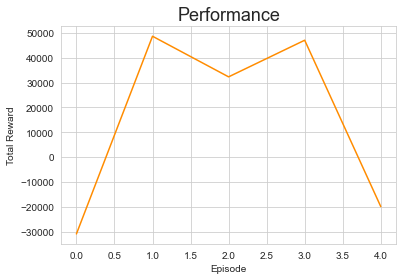

In [28]:
if __name__ == "__main__":
        
    env = SingleStockTradingEnv(data[:1500])
    agent = DDQNAgent(env.state_space, len(env.action_space), 
                      hidden_size=[128,128,128,128,128], 
                      gamma=0.95, 
                      epsilon_decay_factor=0.99995, 
                      maxlen=5000) 
    print(agent)
    
    number_of_episodes = 5
    total_reward = np.zeros(number_of_episodes)
    train_freq = 15
    
    #random scaler
    states = []
    for _ in range(env.n_step):
        action = np.random.choice(env.action_space)
        state, reward, done, info = env.step(action)
        states.append(state)
        if done:
            break
    scaler = StandardScaler()
    scaler.fit(states)
    
    for i in tqdm_notebook(range(number_of_episodes)):
        count = 0
        state = env.reset()
        state = scaler.transform([state])
        
        while True:
            count += 1
            
            action = agent.get_action(state)
           
            next_state, reward, done, info = env.step(action)
            next_state = scaler.transform([next_state])

            agent.save_sample(state, action, reward, next_state, done)
            
            if count % train_freq == 0:
                agent.train_model()
            
            #Update Value
            state = next_state
            total_reward[i] += reward 
    
            if done:
                
                agent.copy_weights(agent.model, agent.target_model)
                
                if total_reward[i]>=total_reward.max():
                    agent.model.save_weights('test_high.h5')
                    
                '''text_file = open("Plot.txt", "a")
                text_file.write('{}\n'.format(total_reward[i]))
                text_file.close()'''
                
                if i % 25 == 0:
                    print(f'Episode: {i+1}')
                    print(f'begin_portfolio_value: {env.begin_portfolio_value:.2f}')
                    print(f'end_portfolio_value: {env.port_val().item():.2f}')
                    print(f'total_reward: {total_reward[i]:.2f}')
                    print(f'average_reward: {total_reward[:i+1].mean():.2f}')
                    print(f'buy: {env.n_buy}, sell: {env.n_sell}')
                    print(f'Epsilon: {agent.epsilon:.5f}')
                    print("=======================================")

                break   
    
    #Save model 
    agent.model.save_weights('test.h5')
        
    plt.plot(total_reward, color='darkorange')
    plt.plot(talib.EMA(total_reward, timeperiod=20))
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Performance',fontsize=18)
    plt.show()                       
            

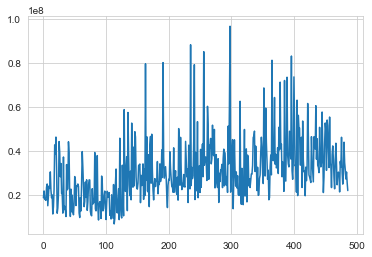

In [29]:
plt.plot(agent.losses)

# Backtest Performance

In [35]:
test_data = data[:1500]
env = SingleStockTradingEnv(test_data)

backtest_model = DenseNetwork(env.state_space, len(env.action_space), [128,128,128,128,128])
backtest_model.build((None, env.state_space))
backtest_model.load_weights('test.h5')

In [36]:
states = []
for _ in range(env.n_step):
    action = np.random.choice(env.action_space)
    state, reward, done, info = env.step(action)
    states.append(state)
    if done:
        break
scaler = StandardScaler()
scaler.fit(states)

state = env.reset()
state = scaler.transform([state])
    
equity_curve = np.empty([env.n_step-1])
total_reward = np.zeros(1)
i = 0
    
#Back test env
while True:
    #print(env.position, env.cash, env.port_val())
    #print(action)
    action = np.argmax(backtest_model.call(state)[0])
    equity_curve[i] =  env.port_val()

    next_state, reward, done, info = env.step(action)
    next_state = scaler.transform([next_state])

    total_reward += reward
    state = next_state
    i += 1
  
    if done:

        print(f'========Backtesting Performance========')
        print(f'begin_portfolio_value: {env.begin_portfolio_value:.2f}')
        print(f'end_portfolio_value: {env.port_val()[0]:.2f}')
        print(f'total_reward: {total_reward[0]:.2f}')
        print(f'buy: {env.n_buy}, sell: {env.n_sell}')
        print("=======================================")

        break

========Backtesting Performance========
begin_portfolio_value: 100000.00
end_portfolio_value: 111012.82
total_reward: 11012.82
buy: 8, sell: 0


In [58]:
def marker_plot(data, action):
    data = data.iloc[:-1,:]
    data['action'] = action
    return data

In [56]:
test_data.loc[]

TypeError: cannot do slice indexing on DatetimeIndex with these indexers [2] of type int

In [59]:
marker_plot(test_data, env.action_plot)

<ipython-input-58-b2bad907ac14>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['action'] = action


,Adj Close,ADX,CCI,RSI,action
Date,,,,,
2000-03-29,31.467127,19.232385,69.108042,54.695377,2
2000-03-30,31.467127,18.739816,65.921232,54.695377,2
2000-03-31,31.467127,17.984587,42.483056,54.695377,2
2000-04-03,31.467127,17.411840,36.080937,54.695377,2
2000-04-04,30.573175,16.412340,-26.353895,50.158834,2
...,...,...,...,...,...
2006-01-11,36.658672,19.548475,46.666667,58.006363,1
2006-01-12,37.082462,19.745863,88.888889,60.617253,1
2006-01-13,37.082462,19.929151,91.561181,60.617253,1


In [46]:
env.action_plot

[2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [37]:
def act_scatter_plot(index_price, action):
    
    list_buy = []
    list_sell = []
    
    for i in range(len(action)-1):
        if action[i] == 2:
            list_buy.append([i+1, index_price[i+1]])
        elif action[i] == 0:
            list_sell.append([i+1, index_price[i+1]])
    
    df_buy = pd.DataFrame(list_buy)
    df_sell = pd.DataFrame(list_sell)
    
    return df_buy, df_sell 

In [38]:
#Set data
act = np.array(env.action_plot)
price = test_data.iloc[:,0][:-1]
df_buy, df_sell = act_scatter_plot(price, act)

KeyError: 0

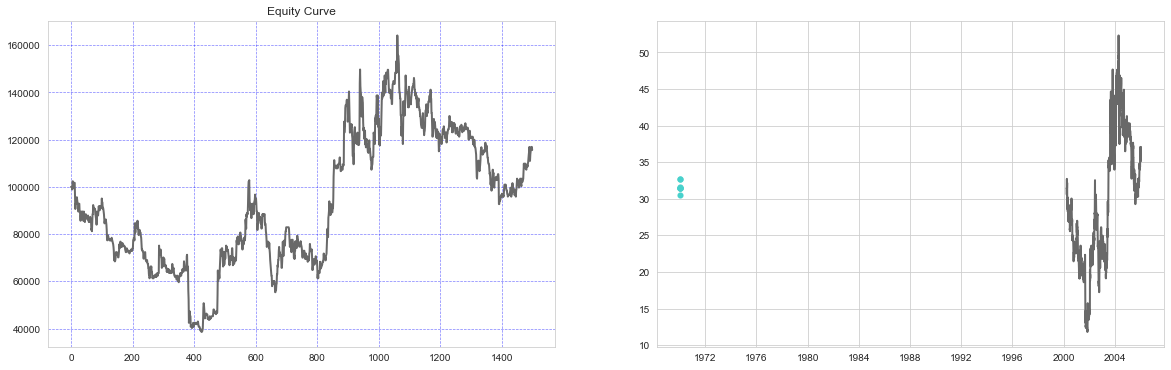

In [39]:
#Plot
fig = plt.figure(figsize=(20,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(equity_curve, color='dimgray',lw=2)
ax1.title.set_text('Equity Curve')
ax1.grid(color='b', alpha=0.5, linestyle='dashed', linewidth=0.7)

ax2.plot(test_data.iloc[:,0], color='dimgray',lw=2)
ax2.scatter(df_buy[0], df_buy[1], color='mediumturquoise', lw=0.1)
ax2.scatter(df_sell[0], df_sell[1], color='goldenrod', lw=0.1)
ax2.title.set_text('Stock Price')
ax2.legend(['stock','buy','sell'])
ax2.grid(color='b', alpha=0.5, linestyle='dashed', linewidth=0.7)